In [ ]:

Standardization - zscore normalization - standard scaler
Normarization - min-max scaler
mean normalization- not used much
max abs scaling - maxabsscaler - for sparse data (not used much)
robust scaler - xi - x_median/(IQR) - (sklearn RobustScaler) - robust to outliers

Normalization vs standardization?
    most of the cases standardization
    min-max-scaler: when we know the min and max -  and we have know fixed min and max for exxample class marks,
    for the start do all.

Encoding of categorical features
    one hot 
    ordinal encoding
    label encoding - similar to ordinal encoder but used when we have categorical output


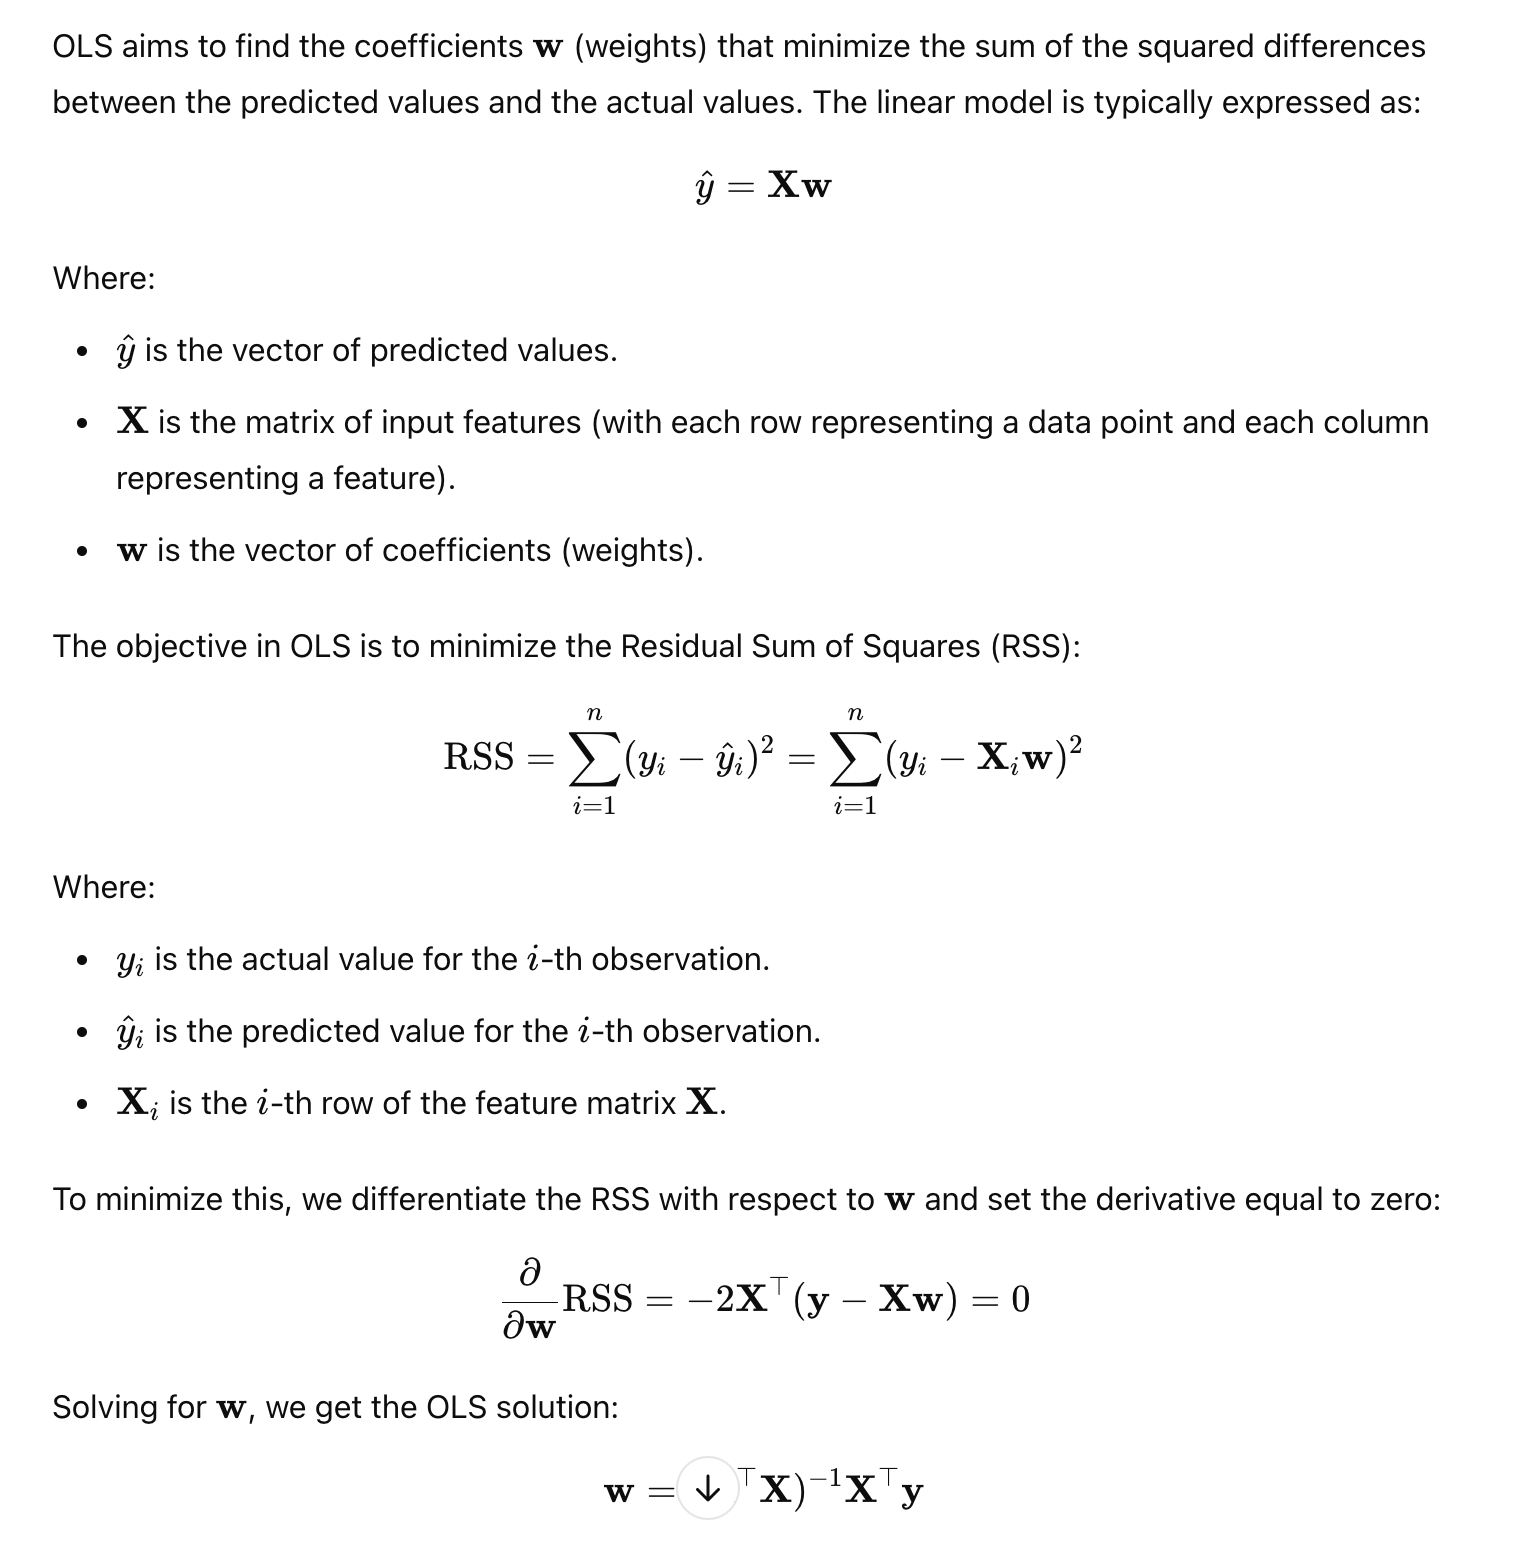

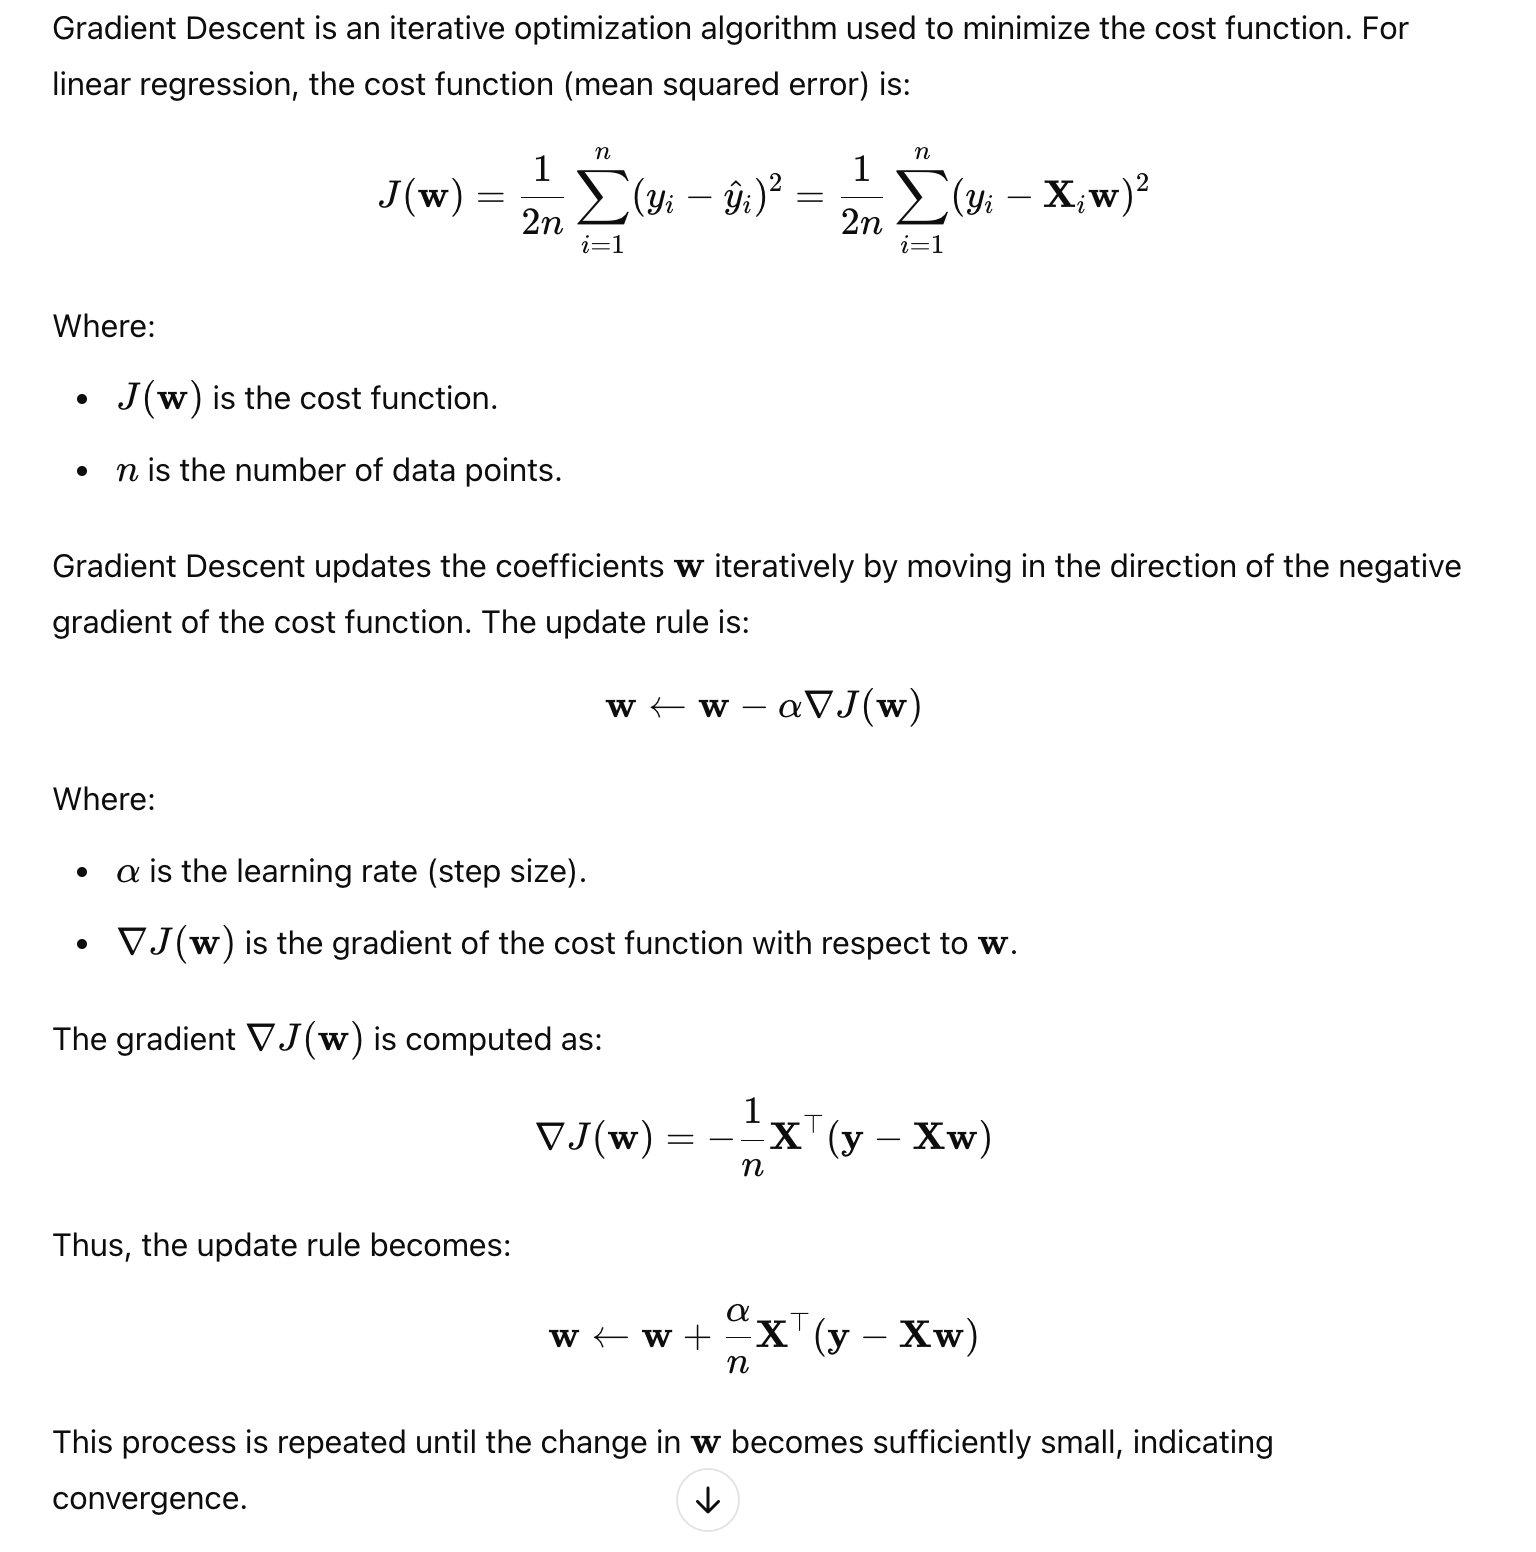

In [ ]:
When is OLS and gradient descent used?

OLS is used when data is small
For larger dataset the Matrix inverse : (X_transpose * X)^-1
becomes infeasible as wwe know that the time complexity of inverse of a matrix is (n^3)

For larger data gradient descent is used as there isnt any inverse operation on matrix
    Gradient descent is widely used because of the wide application as a minimization algortithm.

Original Data:
   Feature1  Feature2 Category OrdinalCategory
0        10         1        A             low
1        20         2        B          medium
2        30         3        A            high
3        40         4        C          medium
4      1000       100        B             low


/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but IsolationForest was fitted with feature names
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(



Transformed Data:
   Feature1  Feature2 Category OrdinalCategory  Feature1_StandardScaled  \
0        10         1        A             low                -0.538285   
1        20         2        B          medium                -0.512652   
2        30         3        A            high                -0.487019   
3        40         4        C          medium                -0.461387   
4      1000       100        B             low                 1.999343   

   Feature1_MinMaxScaled  Feature1_MaxAbsScaled  Feature1_RobustScaled  \
0               0.000000                   0.01                   -1.0   
1               0.010101                   0.02                   -0.5   
2               0.020202                   0.03                    0.0   
3               0.030303                   0.04                    0.5   
4               1.000000                   1.00                   48.5   

   Category_A  Category_B  ...  Feature1_Binned_Cut   Z_Score  \
0         1.0       

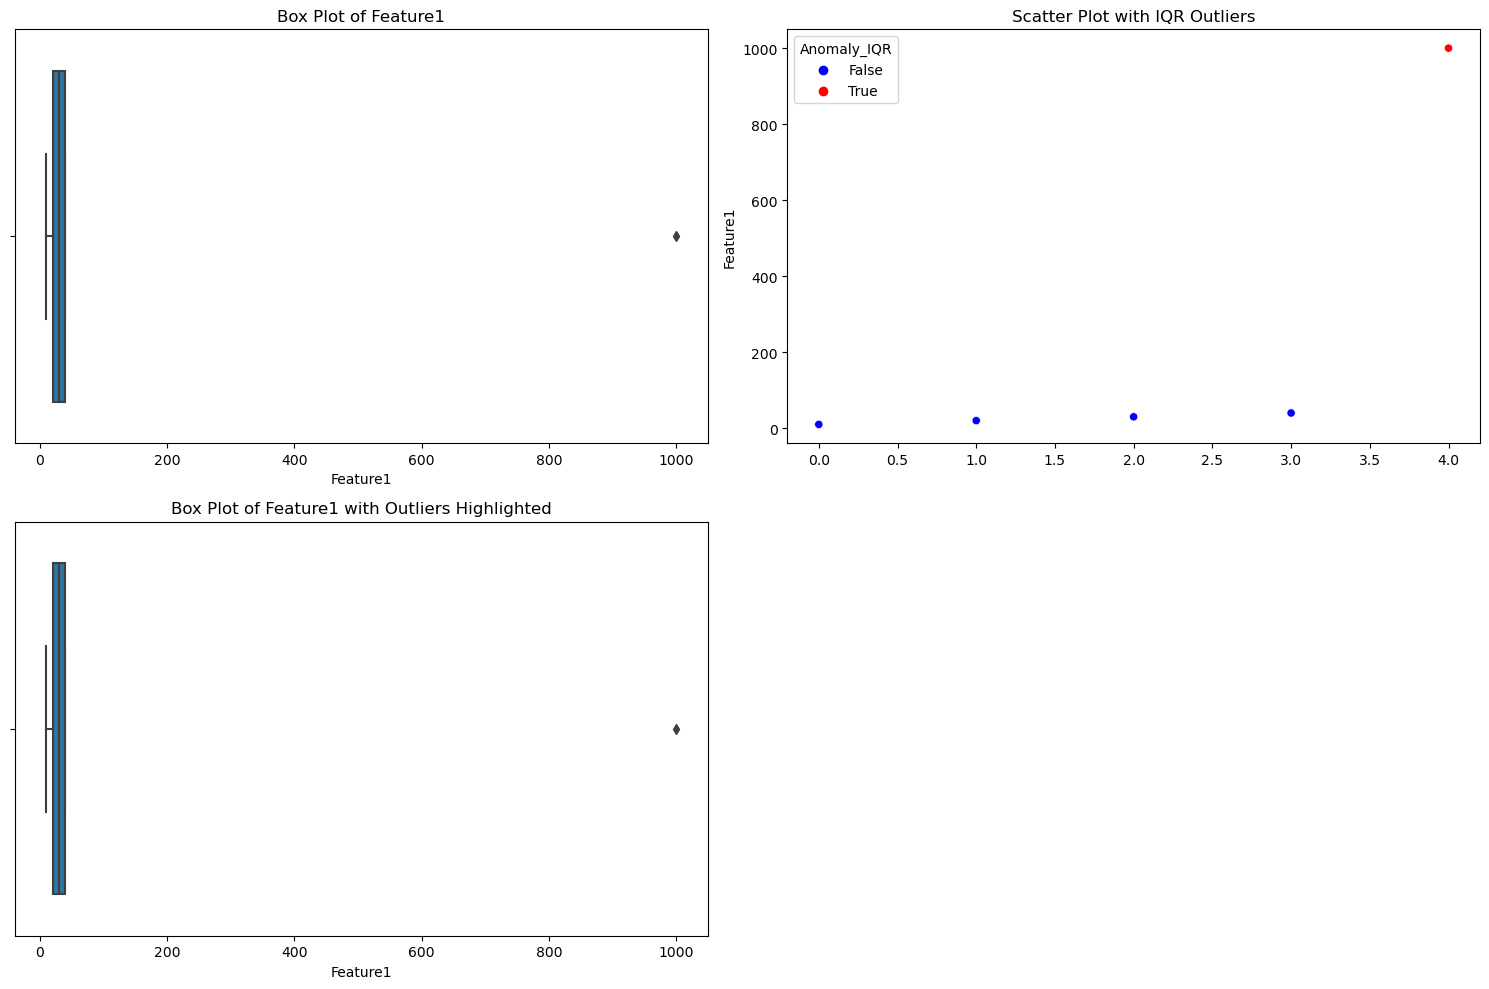


Reverted Encodings:
  Category_Reverted OrdinalCategory_Reverted Category_LabelEncoded_Reverted
0                 A                      low                              A
1                 B                   medium                              B
2                 A                     high                              A
3                 C                   medium                              C
4                 B                      low                              B


In [25]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import (
    StandardScaler, MinMaxScaler, MaxAbsScaler, RobustScaler, 
    OneHotEncoder, OrdinalEncoder, LabelEncoder, 
    PowerTransformer, KBinsDiscretizer
)
from sklearn.ensemble import IsolationForest
from sklearn.svm import OneClassSVM
from sklearn.neighbors import LocalOutlierFactor
from sklearn.covariance import EllipticEnvelope
from sklearn.cluster import DBSCAN, KMeans
from scipy.spatial import distance
from scipy.stats import zscore, iqr

# Sample Data
data = pd.DataFrame({
    'Feature1': [10, 20, 30, 40, 1000],
    'Feature2': [1, 2, 3, 4, 100],
    'Category': ['A', 'B', 'A', 'C', 'B'],
    'OrdinalCategory': ['low', 'medium', 'high', 'medium', 'low']
})

print("Original Data:")
print(data)

# 1. Z-Score Normalization (Standard Scaler)
scaler = StandardScaler()
data['Feature1_StandardScaled'] = scaler.fit_transform(data[['Feature1']])

# 2. Min-Max Scaler
scaler = MinMaxScaler()
data['Feature1_MinMaxScaled'] = scaler.fit_transform(data[['Feature1']])

# 3. Max Abs Scaler
scaler = MaxAbsScaler()
data['Feature1_MaxAbsScaled'] = scaler.fit_transform(data[['Feature1']])

# 4. Robust Scaler
scaler = RobustScaler()
data['Feature1_RobustScaled'] = scaler.fit_transform(data[['Feature1']])

# 5. OneHot Encoding
encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = encoder.fit_transform(data[['Category']])
onehot_df = pd.DataFrame(onehot_encoded, columns=encoder.get_feature_names_out(['Category']))
data = pd.concat([data, onehot_df], axis=1)

# 6. Ordinal Encoding
ordinal_encoder = OrdinalEncoder(categories=[['low', 'medium', 'high']])
data['OrdinalCategory_Encoded'] = ordinal_encoder.fit_transform(data[['OrdinalCategory']])

# 7. Label Encoding
label_encoder = LabelEncoder()
data['Category_LabelEncoded'] = label_encoder.fit_transform(data['Category'])

# 8. Log Transform
data['Feature1_LogTransformed'] = np.log1p(data['Feature1'])  # log1p is used to avoid log(0) issues

# 9. Box-Cox Transform (only works on positive data)
# Ensure data is positive
data['Feature2_BoxCoxTransformed'] = PowerTransformer(method='box-cox').fit_transform(data[['Feature2']])

# 10. Binning using KBinsDiscretizer
binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
data['Feature1_Binned'] = binner.fit_transform(data[['Feature1']])

# 10. Binning using pd.cut
data['Feature1_Binned_Cut'] = pd.cut(data['Feature1'], bins=3, labels=False)

# Outlier Detection Methods
# 11. Z-Score Method
data['Z_Score'] = zscore(data[['Feature1']])
data_no_outliers_zscore = data[data['Z_Score'].abs() < 3]  # Removing outliers based on Z-Score

# 12. Isolation Forest
iso = IsolationForest(contamination=0.2)
data['Anomaly_IsolationForest'] = iso.fit_predict(data[['Feature1']])
data_no_outliers_iso = data[data['Anomaly_IsolationForest'] == 1]

# 13. One-Class SVM
svm = OneClassSVM(nu=0.2)
data['Anomaly_OneClassSVM'] = svm.fit_predict(data[['Feature1']])
data_no_outliers_svm = data[data['Anomaly_OneClassSVM'] == 1]

# 14. Local Outlier Factor
lof = LocalOutlierFactor(n_neighbors=2)
data['Anomaly_LOF'] = lof.fit_predict(data[['Feature1']])
data_no_outliers_lof = data[data['Anomaly_LOF'] == 1]

# 15. Elliptic Envelope
env = EllipticEnvelope(contamination=0.2)
data['Anomaly_EllipticEnvelope'] = env.fit_predict(data[['Feature1']])
data_no_outliers_env = data[data['Anomaly_EllipticEnvelope'] == 1]

# 16. DBSCAN
dbscan = DBSCAN(eps=3, min_samples=2)
data['Anomaly_DBSCAN'] = dbscan.fit_predict(data[['Feature1']])
data_no_outliers_dbscan = data[data['Anomaly_DBSCAN'] != -1]

# 17. K-Means Clustering
kmeans = KMeans(n_clusters=2)
data['Cluster_KMeans'] = kmeans.fit_predict(data[['Feature1']])
distances = np.min(distance.cdist(data[['Feature1']], kmeans.cluster_centers_, 'euclidean'), axis=1)
outliers_kmeans = distances > np.percentile(distances, 95)
data['Anomaly_KMeans'] = np.where(outliers_kmeans, -1, 1)
data_no_outliers_kmeans = data[data['Anomaly_KMeans'] == 1]

# 18. Interquartile Range (IQR) Method
Q1 = data['Feature1'].quantile(0.25)
Q3 = data['Feature1'].quantile(0.75)
IQR = Q3 - Q1
data['Anomaly_IQR'] = (data['Feature1'] < (Q1 - 1.5 * IQR)) | (data['Feature1'] > (Q3 + 1.5 * IQR))
data_no_outliers_iqr = data[~data['Anomaly_IQR']]

print("\nTransformed Data:")
print(data)

# Plotting
plt.figure(figsize=(15, 10))

# Box Plot for IQR
plt.subplot(2, 2, 1)
sns.boxplot(x=data['Feature1'])
plt.title('Box Plot of Feature1')

# Scatter Plot with Outliers
plt.subplot(2, 2, 2)
sns.scatterplot(x=data.index, y=data['Feature1'], hue=data['Anomaly_IQR'], palette={True: 'red', False: 'blue'})
plt.title('Scatter Plot with IQR Outliers')

# Box Plot for all methods
plt.subplot(2, 2, 3)
sns.boxplot(x=data['Feature1'])
plt.title('Box Plot of Feature1 with Outliers Highlighted')

plt.tight_layout()
plt.show()

# Reverting Encodings Back to Original

# Revert OneHot Encoding
reverted_category = encoder.inverse_transform(data[encoder.get_feature_names_out(['Category'])])
data['Category_Reverted'] = pd.Series(reverted_category.flatten(), index=data.index)

# Revert Ordinal Encoding
ordinal_reverted = ordinal_encoder.inverse_transform(data[['OrdinalCategory_Encoded']])
data['OrdinalCategory_Reverted'] = pd.Series(ordinal_reverted.flatten(), index=data.index)

# Revert Label Encoding
data['Category_LabelEncoded_Reverted'] = label_encoder.inverse_transform(data['Category_LabelEncoded'])

print("\nReverted Encodings:")
print(data[['Category_Reverted', 'OrdinalCategory_Reverted', 'Category_LabelEncoded_Reverted']])


# Plan

descriptive statistics
    measure of central tendancy
    measure of dispersion

EDA
    univariate
    bivariate
    mulitvariate

Transformation:
    null treatment:
        
    common:
        scaling/normalization
    numerical:
        binning: convert numerical values into categorical:
                for example: age : age bins to make groups of ages
    categorical:
        ordinal:
            ordinalencoding: categories = []
            ratings["one","two","three"]
        nominal:
            onehotencoding
    outlier detection and removal:
        
    if columns are not normally distributed :
        we do convert the data into normal distrivution
            log transformation
            box cox transformation
modelling:
    model selection:
        choose all the models and fit the data
        for our case we will go for linear/polynomial regression
if the model is linear then we will also check for the assumptions of the data.

evaluation:
    choose the evaluation metrics
redo all the steps from transformation to optimize            

In [1]:
import pandas as pd

In [7]:
# Reading of data
df = pd.read_csv('./Linear Regression Project/Dataset/insurance.csv')

In [ ]:
# Basic descriptive statistics:

In [9]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   age       1338 non-null   int64  
 1   sex       1338 non-null   object 
 2   bmi       1338 non-null   float64
 3   children  1338 non-null   int64  
 4   smoker    1338 non-null   object 
 5   region    1338 non-null   object 
 6   charges   1338 non-null   float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


In [42]:
df.describe(include = 'all')

,age,sex,bmi,children,smoker,region,charges
count,1338.000000,1338,1338.000000,1338.000000,1338,1338,1338.000000
unique,NaN,2,NaN,NaN,2,4,NaN
top,NaN,male,NaN,NaN,no,southeast,NaN
freq,NaN,676,NaN,NaN,1064,364,NaN
mean,39.207025,NaN,30.663397,1.094918,NaN,NaN,13270.422265
std,14.049960,NaN,6.098187,1.205493,NaN,NaN,12110.011237
min,18.000000,NaN,15.960000,0.000000,NaN,NaN,1121.873900
25%,27.000000,NaN,26.296250,0.000000,NaN,NaN,4740.287150
50%,39.000000,NaN,30.400000,1.000000,NaN,NaN,9382.033000
75%,51.000000,NaN,34.693750,2.000000,NaN,NaN,16639.912515


In [21]:
df.head(50)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520
5,31,female,25.740,0,no,southeast,3756.62160
6,46,female,33.440,1,no,southeast,8240.58960
7,37,female,27.740,3,no,northwest,7281.50560
8,37,male,29.830,2,no,northeast,6406.41070
9,60,female,25.840,0,no,northwest,28923.13692


In [44]:
df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

In [430]:
import matplotlib.pyplot as plt
import seaborn as sns

def category_eda(df,cols_list ):
    for cols in cols_list:
            sns.countplot(data = df,x = cols)
            plt.show()
            print (df[cols].value_counts())
            print (df[cols].value_counts(normalize = True))
def numerical_eda(df,cols_list):
    for col in cols_list:
        sns.boxplot(data = df,x = col)
        plt.show()
        sns.displot(data = df,x= col,kde = True)
        plt.show()

def relation_pairs(df,cols_list):
    sns.pairplot(df[cols_list])
    # multivariate

    # correlation/heatmap
    
    sns.heatmap(df[cols_list].corr(),annot = True)

In [ ]:
# univariate numerical
categorical_cols = ['sex','smoker', 'region']
numerical_cols = list(set(df.columns.tolist()) - set(cat_col_list))

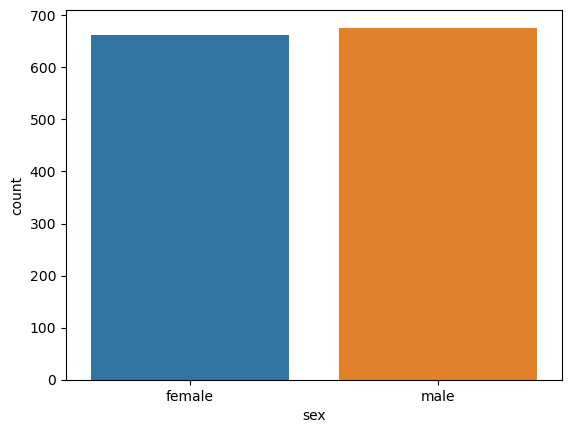

sex
male      676
female    662
Name: count, dtype: int64


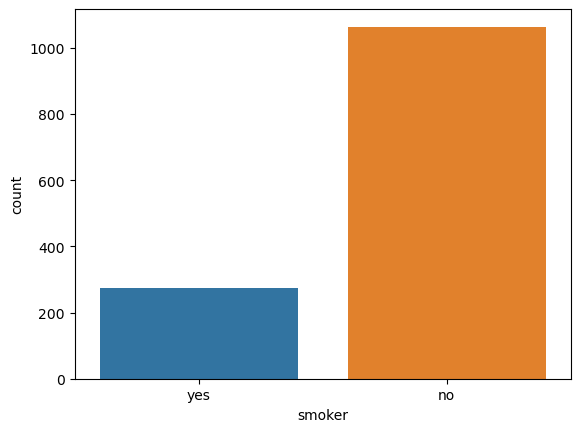

smoker
no     1064
yes     274
Name: count, dtype: int64


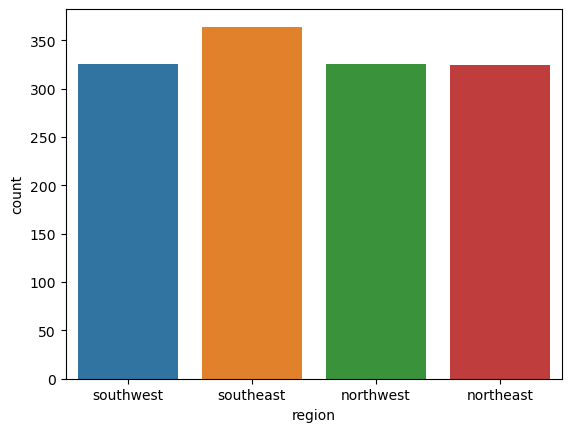

region
southeast    364
southwest    325
northwest    325
northeast    324
Name: count, dtype: int64


In [142]:
category_eda(df,categorical_cols )

<Axes: xlabel='sex', ylabel='count'>

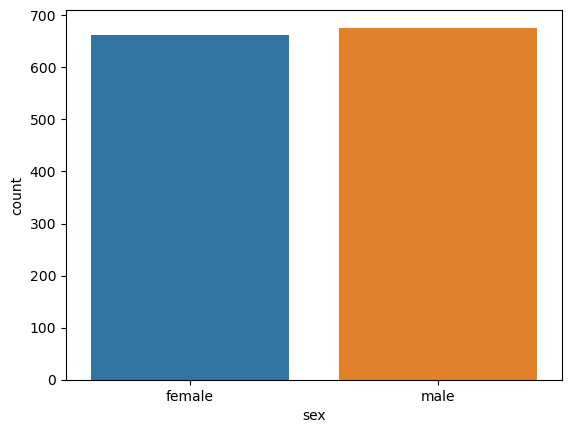

In [68]:
# univariate
    # categorical
sns.countplot(data = df,x = 'sex')

<Axes: xlabel='smoker', ylabel='count'>

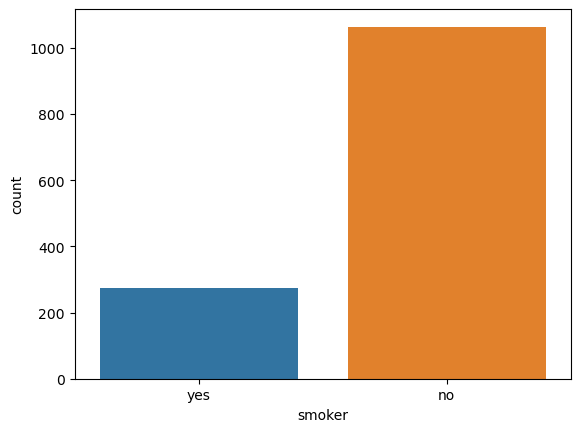

In [64]:
sns.countplot(data = df,x = 'smoker')


<Axes: xlabel='region', ylabel='count'>

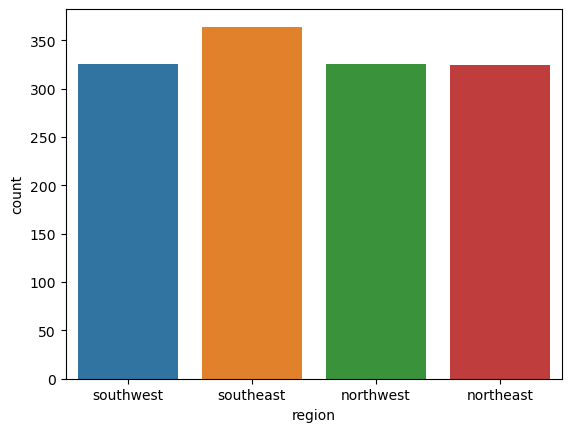

In [66]:
sns.countplot(data = df,x = 'region')

In [140]:
numerical_cols

['charges', 'children', 'age', 'bmi']

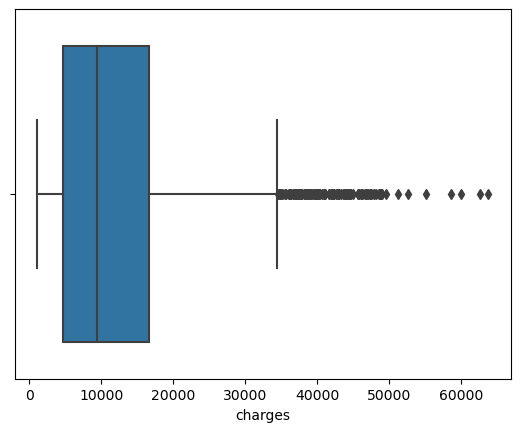

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


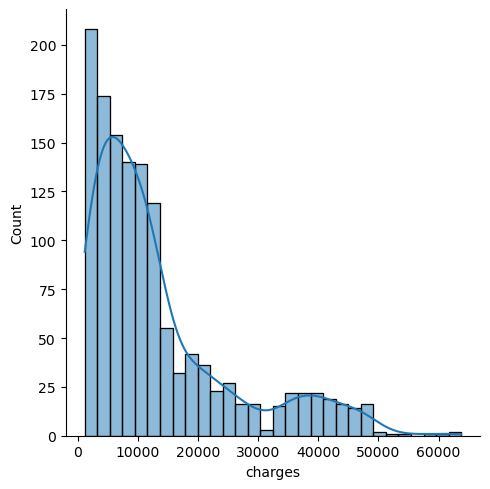

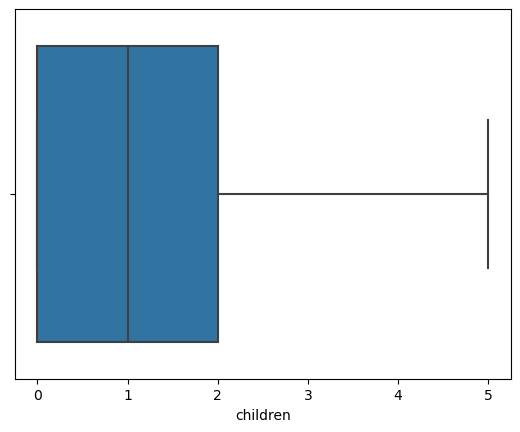

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


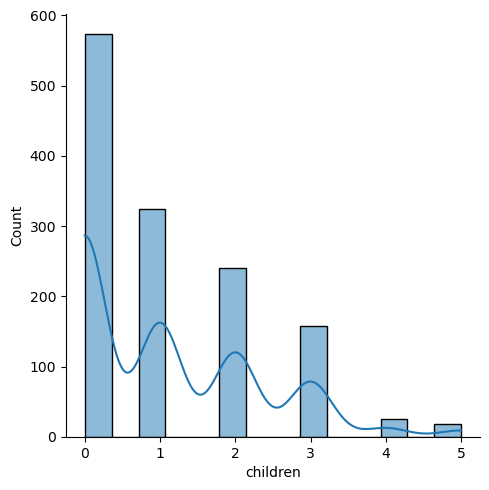

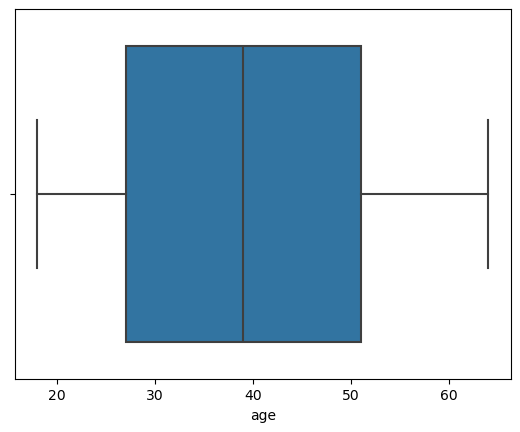

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


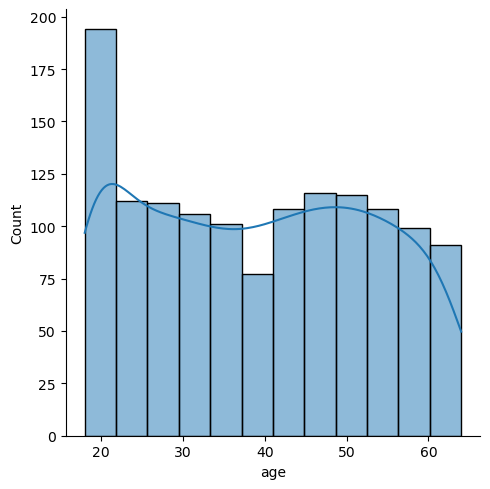

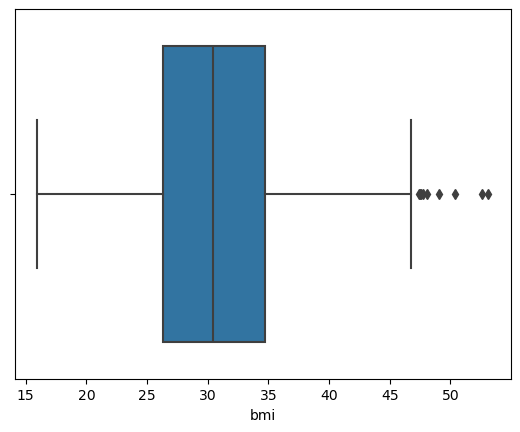

/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):


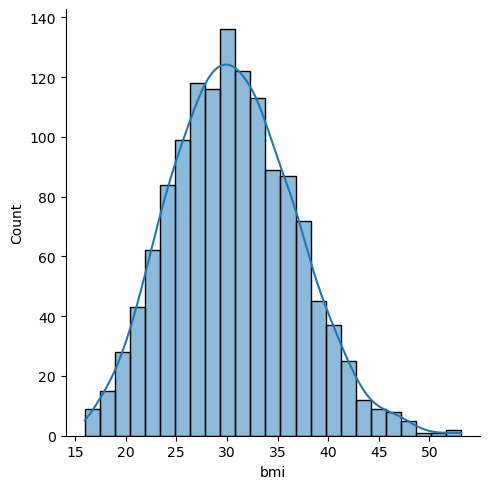

In [118]:
numerical_eda(df,numerical_cols)

In [150]:
# transformation

# categorical- 

# categorical_cols

from sklearn.preprocessing import OneHotEncoder

In [152]:
categorical_cols

['sex', 'smoker', 'region']

In [170]:
onehot_encoded

array([[1., 0., 0., ..., 0., 0., 1.],
       [0., 1., 1., ..., 0., 1., 0.],
       [0., 1., 1., ..., 0., 1., 0.],
       ...,
       [1., 0., 1., ..., 0., 1., 0.],
       [1., 0., 1., ..., 0., 0., 1.],
       [1., 0., 0., ..., 1., 0., 0.]])

In [166]:
encoder = OneHotEncoder(sparse_output=False)
onehot_encoded = encoder.fit_transform(df[categorical_cols])
onehot_df = pd.DataFrame(onehot_encoded, columns=encoder.get_feature_names_out(categorical_cols))
df_proc = pd.concat([df, onehot_df], axis=1)

In [168]:
df_proc

,age,sex,bmi,children,smoker,region,charges,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
0,19,female,27.900,0,yes,southwest,16884.92400,1.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0
1,18,male,33.770,1,no,southeast,1725.55230,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
2,28,male,33.000,3,no,southeast,4449.46200,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0
3,33,male,22.705,0,no,northwest,21984.47061,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
4,32,male,28.880,0,no,northwest,3866.85520,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,50,male,30.970,3,no,northwest,10600.54830,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0
1334,18,female,31.920,0,no,northeast,2205.98080,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0
1335,18,female,36.850,0,no,southeast,1629.83350,1.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0
1336,21,female,25.800,0,no,southwest,2007.94500,1.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0


In [196]:
categorical_cols + ['charges']

['sex', 'smoker', 'region', 'charges']

In [192]:
X = df_proc.drop(columns = categorical_cols + ['charges'])
y = df_proc['charges']

In [198]:
X,y

(      age     bmi  children  sex_female  sex_male  smoker_no  smoker_yes  \
 0      19  27.900         0         1.0       0.0        0.0         1.0   
 1      18  33.770         1         0.0       1.0        1.0         0.0   
 2      28  33.000         3         0.0       1.0        1.0         0.0   
 3      33  22.705         0         0.0       1.0        1.0         0.0   
 4      32  28.880         0         0.0       1.0        1.0         0.0   
 ...   ...     ...       ...         ...       ...        ...         ...   
 1333   50  30.970         3         0.0       1.0        1.0         0.0   
 1334   18  31.920         0         1.0       0.0        1.0         0.0   
 1335   18  36.850         0         1.0       0.0        1.0         0.0   
 1336   21  25.800         0         1.0       0.0        1.0         0.0   
 1337   61  29.070         0         1.0       0.0        0.0         1.0   
 
       region_northeast  region_northwest  region_southeast  region_southw

In [206]:
from sklearn.model_selection import train_test_split

In [208]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size = 0.2,random_state = 42)

In [296]:
X_train,y_train

(      age     bmi  children  sex_female  sex_male  smoker_no  smoker_yes  \
 560    46  19.950         2         1.0       0.0        1.0         0.0   
 1285   47  24.320         0         1.0       0.0        1.0         0.0   
 1142   52  24.860         0         1.0       0.0        1.0         0.0   
 969    39  34.320         5         1.0       0.0        1.0         0.0   
 486    54  21.470         3         1.0       0.0        1.0         0.0   
 ...   ...     ...       ...         ...       ...        ...         ...   
 1095   18  31.350         4         1.0       0.0        1.0         0.0   
 1130   39  23.870         5         1.0       0.0        1.0         0.0   
 1294   58  25.175         0         0.0       1.0        1.0         0.0   
 860    37  47.600         2         1.0       0.0        0.0         1.0   
 1126   55  29.900         0         0.0       1.0        1.0         0.0   
 
       region_northeast  region_northwest  region_southeast  region_southw

In [298]:
X_test,y_test

(      age     bmi  children  sex_female  sex_male  smoker_no  smoker_yes  \
 764    45  25.175         2         1.0       0.0        1.0         0.0   
 887    36  30.020         0         1.0       0.0        1.0         0.0   
 890    64  26.885         0         1.0       0.0        0.0         1.0   
 1293   46  25.745         3         0.0       1.0        1.0         0.0   
 259    19  31.920         0         0.0       1.0        0.0         1.0   
 ...   ...     ...       ...         ...       ...        ...         ...   
 109    63  35.090         0         0.0       1.0        0.0         1.0   
 575    58  27.170         0         1.0       0.0        1.0         0.0   
 535    38  28.025         1         0.0       1.0        1.0         0.0   
 543    54  47.410         0         1.0       0.0        0.0         1.0   
 846    51  34.200         1         1.0       0.0        1.0         0.0   
 
       region_northeast  region_northwest  region_southeast  region_southw

In [402]:
categorical_eda(df_proc,['age_bins','bmi_bins'])

NameError: name 'categorical_eda' is not defined

In [200]:
from sklearn.linear_model import LinearRegression,Ridge,Lasso

In [202]:
lr = LinearRegression()

In [214]:
lr.fit(X_train,y_train)

LinearRegression()

In [226]:
lr.intercept_,lr.coef_

(-574.5357125101946,
 array([ 2.56975706e+02,  3.37092552e+02,  4.25278784e+02,  9.29584582e+00,
        -9.29584582e+00, -1.18255644e+04,  1.18255644e+04,  4.59585244e+02,
         8.89079180e+01, -1.98279052e+02, -3.50214110e+02]))

In [308]:
X_test.head(1)

,age,bmi,children,sex_female,sex_male,smoker_no,smoker_yes,region_northeast,region_northwest,region_southeast,region_southwest
764,45,25.175,2,1.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0


In [316]:
lr.predict(np.array([45,	25.175,	2,	1.0,	0.0,	1.0,	0.0,	1.0,	0.0,	0.0,	0.0
]).reshape(1, -1))
# y_pred = lr.predict(X_test)

/opt/anaconda3/lib/python3.11/site-packages/sklearn/base.py:439: UserWarning: X does not have valid feature names, but LinearRegression was fitted with feature names
  warnings.warn(


array([8969.55027444])

In [318]:
y_pred = lr.predict(X_test)

In [320]:
y_test,y_pred

(764      9095.06825
 887      5272.17580
 890     29330.98315
 1293     9301.89355
 259     33750.29180
            ...     
 109     47055.53210
 575     12222.89830
 535      6067.12675
 543     63770.42801
 846      9872.70100
 Name: charges, Length: 268, dtype: float64,
 array([ 8969.55027444,  7068.74744287, 36858.41091155,  9454.67850053,
        26973.17345656, 10864.11316424,   170.28084137, 16903.45028662,
         1092.43093614, 11218.34318352, 28101.68455267,  9377.73460205,
         5263.0595179 , 38416.04221107, 40255.82339284, 37098.25353123,
        15240.39392306, 35912.88264434,  9112.52398703, 31461.92108909,
         3847.68845883, 10130.12001517,  2370.54189389,  7140.21550828,
        11301.76782638, 12961.65366224, 14509.47251876,  6159.8976107 ,
         9963.85857263,  2177.85718217,  9115.93673493, 13073.68932159,
         4561.82376202,  3408.20756033,  4459.81359745, 13032.06505076,
         1979.99357292,  8813.28303302, 33271.29124448, 32585.51583927,
    

In [278]:
from sklearn.metrics import mean_squared_error, r2_score,mean_absolute_error,mean_absolute_percentage_error
def regression_eval(y_pred,y_test):
    print ("mean squared error",mean_squared_error(y_pred,y_test))
    print("mean absolute error",mean_absolute_error(y_pred,y_test))
    print ("mean abs percentage error",mean_absolute_percentage_error(y_pred,y_test))
    print ("r2_score",r2_score(y_pred,y_test))
    # print ("adjusted_r2_score",)

In [280]:
regression_eval(y_pred,y_test)

mean squared error 33596915.851361476
mean absolute error 4181.194473753645
mean abs percentage error 0.5829456643852924
r2_score 0.7088351277198337


When to use lasso and ridge?
    Lasso minimizes the weights close to 0 or 0 
        thus can be used for feature selection
        and when we have a large number of features and we want few of the features with less relevance to be removed
    Ridge is used when we have lesser number of features or
        we dont want any of the features to be dropped 
    

In [256]:
ridge = Ridge()

In [258]:
ridge

Ridge()

In [272]:
ridge.fit(X_train,y_train)

Ridge()

In [282]:
y_pred_ridge = ridge.predict(X_test)

In [284]:
regression_eval(y_pred_ridge,y_test)

mean squared error 33619947.007616326
mean absolute error 4187.302782980897
mean abs percentage error 0.5981336624944501
r2_score 0.7072631124553965


In [288]:
lasso = Lasso()
lasso.fit(X_train,y_train)
y_pred_lasso = lasso.predict(X_test)

In [290]:
regression_eval(y_pred_ridge,y_test)

mean squared error 33619947.007616326
mean absolute error 4187.302782980897
mean abs percentage error 0.5981336624944501
r2_score 0.7072631124553965


In [ ]:
# Transformation
# EDA

In [328]:
# 
# numerical_eda(df,['age','bmi'])
# df['age'].min(),df['age'].max(),df['age'].value_counts()
pd.cut

(18,
 64,
 age
 18    69
 19    68
 50    29
 51    29
 47    29
 46    29
 45    29
 20    29
 48    29
 52    29
 22    28
 49    28
 54    28
 53    28
 21    28
 26    28
 24    28
 25    28
 28    28
 27    28
 23    28
 43    27
 29    27
 30    27
 41    27
 42    27
 44    27
 31    27
 40    27
 32    26
 33    26
 56    26
 34    26
 55    26
 57    26
 37    25
 59    25
 58    25
 36    25
 38    25
 35    25
 39    25
 61    23
 60    23
 63    23
 62    23
 64    22
 Name: count, dtype: int64)

In [330]:
# 
from sklearn.preprocessing import KBinsDiscretizer
# 10. Binning using KBinsDiscretizer
binner = KBinsDiscretizer(n_bins=3, encode='ordinal', strategy='uniform')
df_proc['age_bins'] = binner.fit_transform(df_proc[['age']])

In [332]:
df_proc.age_bins

0       0.0
1       0.0
2       0.0
3       0.0
4       0.0
       ... 
1333    2.0
1334    0.0
1335    0.0
1336    0.0
1337    2.0
Name: age_bins, Length: 1338, dtype: float64

In [364]:
# 10. Binning using pd.cut
# [vals for vals in range(10,101,5)]
np.arange(10,101,5)
df_proc['age_bins'] = pd.cut(df_proc['age'], bins=np.arange(10,101,5))

In [390]:
df_proc['age_bins'].value_counts()
df_proc['age_bins'][0]

Interval(15, 20, closed='right')

In [378]:
df['bmi'].min(),df['bmi'].max(),df['bmi'].value_counts()

(15.96,
 53.13,
 bmi
 32.300    13
 28.310     9
 30.495     8
 30.875     8
 31.350     8
           ..
 46.200     1
 23.800     1
 44.770     1
 32.120     1
 30.970     1
 Name: count, Length: 548, dtype: int64)

In [393]:
df_proc['bmi_bins'] = pd.cut(df_proc['bmi'], bins=np.arange(10,101,5))

In [397]:
df_proc['bmi_bins'].value_counts()

bmi_bins
(30, 35]     389
(25, 30]     386
(35, 40]     225
(20, 25]     206
(40, 45]      71
(15, 20]      41
(45, 50]      17
(50, 55]       3
(10, 15]       0
(75, 80]       0
(90, 95]       0
(85, 90]       0
(80, 85]       0
(55, 60]       0
(70, 75]       0
(65, 70]       0
(60, 65]       0
(95, 100]      0
Name: count, dtype: int64

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


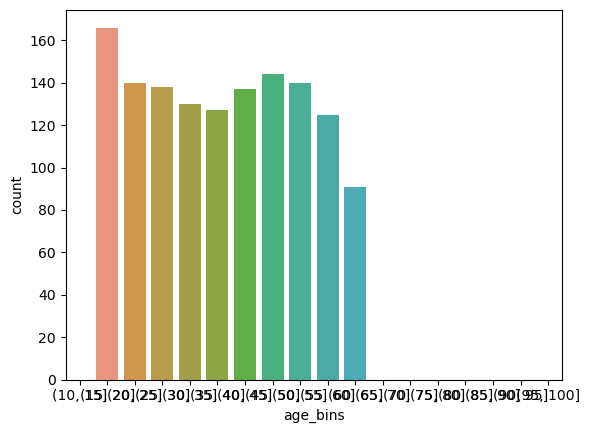

/opt/anaconda3/lib/python3.11/site-packages/seaborn/categorical.py:641: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  grouped_vals = vals.groupby(grouper)


age_bins
(15, 20]     166
(45, 50]     144
(20, 25]     140
(50, 55]     140
(25, 30]     138
(40, 45]     137
(30, 35]     130
(35, 40]     127
(55, 60]     125
(60, 65]      91
(80, 85]       0
(90, 95]       0
(85, 90]       0
(10, 15]       0
(75, 80]       0
(70, 75]       0
(65, 70]       0
(95, 100]      0
Name: count, dtype: int64
age_bins
(15, 20]     0.124066
(45, 50]     0.107623
(20, 25]     0.104634
(50, 55]     0.104634
(25, 30]     0.103139
(40, 45]     0.102392
(30, 35]     0.097160
(35, 40]     0.094918
(55, 60]     0.093423
(60, 65]     0.068012
(80, 85]     0.000000
(90, 95]     0.000000
(85, 90]     0.000000
(10, 15]     0.000000
(75, 80]     0.000000
(70, 75]     0.000000
(65, 70]     0.000000
(95, 100]    0.000000
Name: proportion, dtype: float64


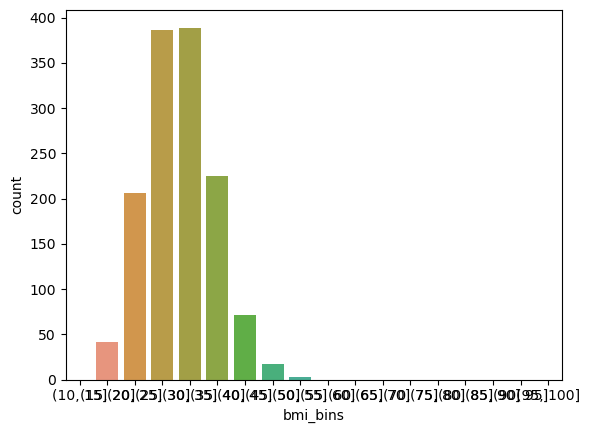

bmi_bins
(30, 35]     389
(25, 30]     386
(35, 40]     225
(20, 25]     206
(40, 45]      71
(15, 20]      41
(45, 50]      17
(50, 55]       3
(10, 15]       0
(75, 80]       0
(90, 95]       0
(85, 90]       0
(80, 85]       0
(55, 60]       0
(70, 75]       0
(65, 70]       0
(60, 65]       0
(95, 100]      0
Name: count, dtype: int64
bmi_bins
(30, 35]     0.290732
(25, 30]     0.288490
(35, 40]     0.168161
(20, 25]     0.153961
(40, 45]     0.053064
(15, 20]     0.030643
(45, 50]     0.012706
(50, 55]     0.002242
(10, 15]     0.000000
(75, 80]     0.000000
(90, 95]     0.000000
(85, 90]     0.000000
(80, 85]     0.000000
(55, 60]     0.000000
(70, 75]     0.000000
(65, 70]     0.000000
(60, 65]     0.000000
(95, 100]    0.000000
Name: proportion, dtype: float64


In [432]:
category_eda(df_proc,['age_bins','bmi_bins'])

In [444]:
# convertion of continous values to categorical done. Next step is to encode these values (nominal/ one hot encoding)

ohe = OneHotEncoder(sparse_output=False)
onehot_encoded = ohe.fit_transform(df_proc[['age_bins','bmi_bins']])


['age_bins_(15, 20]',
 'age_bins_(20, 25]',
 'age_bins_(25, 30]',
 'age_bins_(30, 35]',
 'age_bins_(35, 40]',
 'age_bins_(40, 45]',
 'age_bins_(45, 50]',
 'age_bins_(50, 55]',
 'age_bins_(55, 60]',
 'age_bins_(60, 65]',
 'bmi_bins_(15, 20]',
 'bmi_bins_(20, 25]',
 'bmi_bins_(25, 30]',
 'bmi_bins_(30, 35]',
 'bmi_bins_(35, 40]',
 'bmi_bins_(40, 45]',
 'bmi_bins_(45, 50]',
 'bmi_bins_(50, 55]',
 'sex_female',
 'sex_male',
 'smoker_no',
 'smoker_yes',
 'region_northeast',
 'region_northwest',
 'region_southeast',
 'region_southwest',
 'charges',
 'children',
 'age',
 'bmi']

In [ ]:
# othe way was to concat the encoded df to the older X


In [458]:
onehot_df = pd.DataFrame(onehot_encoded,columns = ohe.get_feature_names_out(['age_bins','bmi_bins']))
# df_proc = pd.concat([df_proc, onehot_df], axis=1)

In [460]:
onehot_df

,"age_bins_(15, 20]","age_bins_(20, 25]","age_bins_(25, 30]","age_bins_(30, 35]","age_bins_(35, 40]","age_bins_(40, 45]","age_bins_(45, 50]","age_bins_(50, 55]","age_bins_(55, 60]","age_bins_(60, 65]","bmi_bins_(15, 20]","bmi_bins_(20, 25]","bmi_bins_(25, 30]","bmi_bins_(30, 35]","bmi_bins_(35, 40]","bmi_bins_(40, 45]","bmi_bins_(45, 50]","bmi_bins_(50, 55]"
0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
1,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
2,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
3,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1333,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1334,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1335,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
1336,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0


In [462]:
df_proc = pd.concat([df_proc, onehot_df], axis=1)

In [466]:
df_proc.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges',
       'sex_female', 'sex_male', 'smoker_no', 'smoker_yes', 'region_northeast',
       'region_northwest', 'region_southeast', 'region_southwest', 'age_bins',
       'bmi_bins', 'age_bins_(15, 20]', 'age_bins_(20, 25]',
       'age_bins_(25, 30]', 'age_bins_(30, 35]', 'age_bins_(35, 40]',
       'age_bins_(40, 45]', 'age_bins_(45, 50]', 'age_bins_(50, 55]',
       'age_bins_(55, 60]', 'age_bins_(60, 65]', 'bmi_bins_(15, 20]',
       'bmi_bins_(20, 25]', 'bmi_bins_(25, 30]', 'bmi_bins_(30, 35]',
       'bmi_bins_(35, 40]', 'bmi_bins_(40, 45]', 'bmi_bins_(45, 50]',
       'bmi_bins_(50, 55]'],
      dtype='object')

In [472]:
ohe.get_feature_names_out(['age_bins','bmi_bins'])


array(['age_bins_(15, 20]', 'age_bins_(20, 25]', 'age_bins_(25, 30]',
       'age_bins_(30, 35]', 'age_bins_(35, 40]', 'age_bins_(40, 45]',
       'age_bins_(45, 50]', 'age_bins_(50, 55]', 'age_bins_(55, 60]',
       'age_bins_(60, 65]', 'bmi_bins_(15, 20]', 'bmi_bins_(20, 25]',
       'bmi_bins_(25, 30]', 'bmi_bins_(30, 35]', 'bmi_bins_(35, 40]',
       'bmi_bins_(40, 45]', 'bmi_bins_(45, 50]', 'bmi_bins_(50, 55]'],
      dtype=object)

In [520]:
cols_to_select =  \
ohe.get_feature_names_out(['age_bins','bmi_bins']).tolist() \
+ encoder.get_feature_names_out(categorical_cols).tolist() + ['children']



In [532]:
cols_to_select
# Scaling
sc = StandardScaler()
df_proc['children_scaled'] = sc.fit_transform(np.array(df_proc['children']).reshape(-1, 1))


0      -0.908614
1      -0.078767
2       1.580926
3      -0.908614
4      -0.908614
          ...   
1333    1.580926
1334   -0.908614
1335   -0.908614
1336   -0.908614
1337   -0.908614
Name: children_scaled, Length: 1338, dtype: float64

In [ ]:
# Normalization


In [512]:
X = df_proc[cols_to_select]
y = df_proc['charges']

In [514]:
from sklearn.model_selection import train_test_split

In [516]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.2,random_state = 42)

In [ ]:
# model creation/function creation



In [ ]:
# Prediction


In [ ]:
# evaluation part
regression_eval()

# 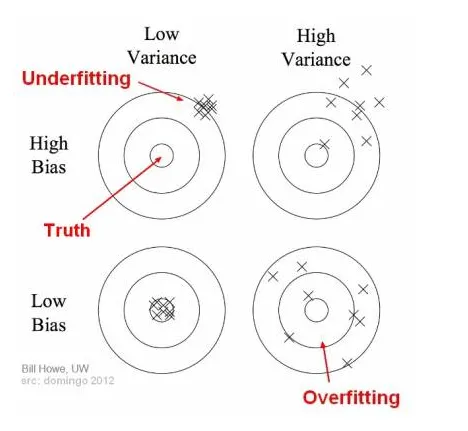
bias variance trade - off



In [ ]:
bias variance tradeoff -  intiuition
it is concept in machine learning that describe the relationship between a model complexity and its accuracy.
y =  ax1 +  b
If we increase the bias to near to infinity (or very high) then the a would go near to 0
    : this would mean there is no contribution of x1 in predicting the y
    : soo this is a case of underfitting
alternatively if we decrease the bias near to 0 / zero then the a would be high near to infinity
    : this would mean that the model has overfitted / tried to learn or capture all the data points
    : soo the model would give high errors on the new data, 
        thus the error variability on the new data points would be high
